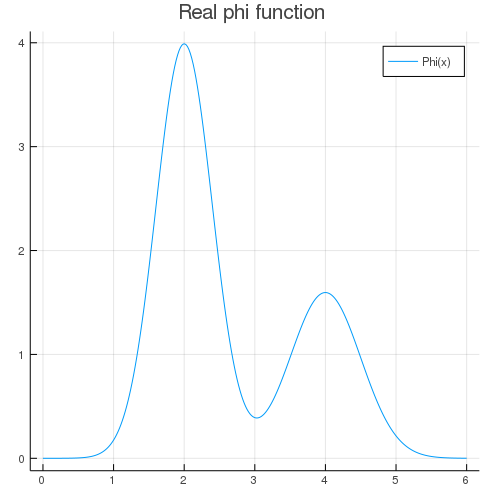

In [62]:
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)

include("../src/gauss_error.jl")
include("../src/kernels.jl")

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))
myplot = plot(x, phi.(x), title="Real phi function",label=["Phi(x)"])
# savefig("real_phi.png")

In [66]:
kernel(x::Real, y::Real) = getOpticsKernels("gaussian")(x, y)

convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)

sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise
plot(y, f, title="Integrated function",label=["f(y)"],seriestype=:scatter, yerr=sig)
savefig("integrated.png")

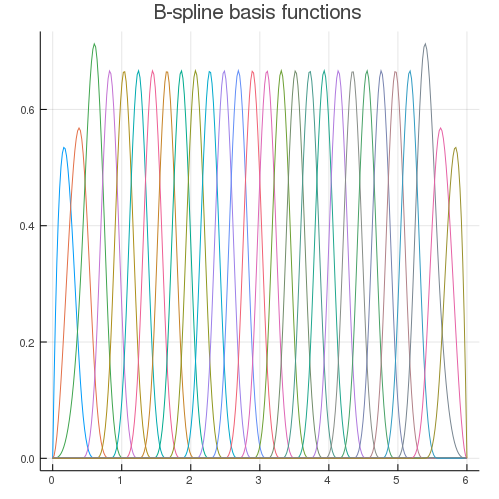

┌ Info: Cubic spline basis is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:235


In [59]:
basis = CubicSplineBasis(y, "dirichlet")
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.f.(x), title="B-spline basis functions", legend=false, show = true)
end
display(p)
# savefig("basis.png")

In [45]:
Omega = omega(basis, 2)
model = GaussErrorUnfolder(basis, [Omega], "EmpiricalBayes", nothing, [1e-8], [10.], [0.3])
println()

┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:66
┌ Info: GaussErrorUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:170


In [46]:
result = solve(model, kernel, f, sig, y)
println()

┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:203
┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:46
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:57
┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:96
┌ Info: Starting find_optimal_alpha...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:122
┌ Info: Starting optimization...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:147


Iter     Function value   Gradient norm 
     0    -4.524371e+02     8.802960e+00
     1    -4.586930e+02     1.861424e+00
     2    -4.591032e+02     5.347496e-02
     3    -4.591035e+02     3.776956e-06
     4    -4.591035e+02     2.336606e-08
     5    -4.591035e+02     2.336606e-08


┌ Info: Optimized successfully, alphas = [0.0600728].
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:162
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:114


┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:211


In [60]:
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Reconstructed function with errors")
plot!(x, phi.(x), label="Real function")
savefig("reconstructed.png")

┌ Info: PhiVec is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:69


In [61]:
length(basis)

28